## Train and Prediction on valid

QC of reslts for final model in 03_11_fastai_train_resnet_20191108.ipynb

Using rotated to hz + OpenCv border

Basic default transforms, QC of images

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import itertools
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from PIL import Image as pil_image

In [4]:
torch.cuda.set_device(2)
torch.cuda.current_device()

1

In [5]:
data_dir = Path('data')

In [6]:
RETRAIN = True
RESIZE_IMAGES = True

In [7]:
MODEL_NAME='cv_reflect_101_valid'

In [8]:
NB_NUM='03_11'

In [9]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: b22b05a3, DATE: 20191109


In [10]:
DATE = '20191109'
UID = '123cca5f'

In [11]:
SUB_NUM='15'

In [12]:
img_size=256

In [13]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [14]:
test_names = get_image_files(test_images)

In [15]:
assert len(test_names)==7325

In [16]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [17]:
df_all.tail()

id  roof_material  verified   country      region
22548  7a22ddec  healthy_metal     False  st_lucia  gros_islet
22549  7a2f73ea  healthy_metal     False  st_lucia  gros_islet
22550  7a34ffa4  healthy_metal     False  st_lucia  gros_islet
22551  7a41560a  healthy_metal     False  st_lucia  gros_islet
22552  7a283ad0  healthy_metal     False  st_lucia  gros_islet

In [19]:
df_st_lucia=df_all.loc[df_all['country'] == 'st_lucia']

In [30]:
df_st_lucia_valid=df_st_lucia.loc[df_st_lucia['verified'] == True]

In [47]:
df_st_lucia_castries_valid=df_st_lucia_valid.loc[df_st_lucia_valid['region'] == 'castries']

In [48]:
df_st_lucia_dennery_valid=df_st_lucia_valid.loc[df_st_lucia_valid['region'] == 'dennery']

In [49]:
df_st_lucia_gros_islet_valid=df_st_lucia_valid.loc[df_st_lucia_valid['region'] == 'gros_islet']

In [28]:
df_colombia=df_all.loc[df_all['country'] == 'colombia']

In [31]:
df_colombia_valid=df_colombia.loc[df_colombia['verified'] == True]

In [21]:
df_guatemala=df_all.loc[df_all['country'] == 'guatemala']

In [32]:
df_guatemala_valid=df_guatemala.loc[df_guatemala['verified'] == True]

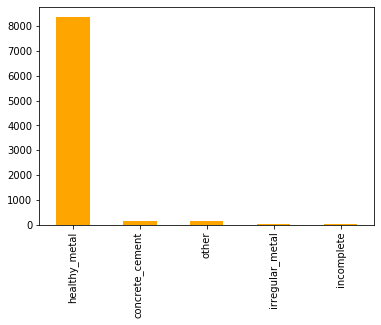

In [23]:
df_st_lucia['roof_material'].value_counts().plot(kind='bar', color='orange')

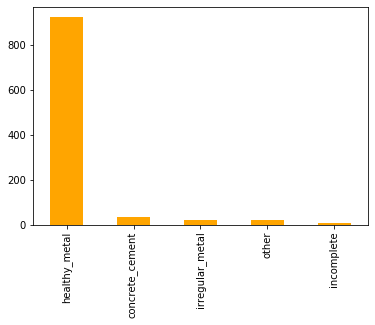

In [33]:
df_st_lucia_valid['roof_material'].value_counts().plot(kind='bar', color='orange')

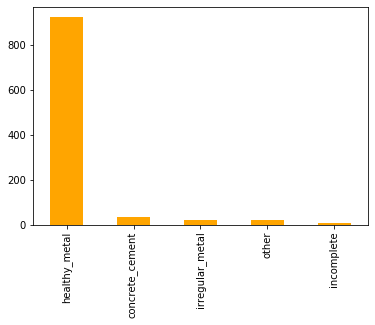

In [51]:
df_st_lucia_dennery_valid['roof_material'].value_counts().plot(kind='bar', color='orange')

In [52]:
len(df_st_lucia_castries_valid)

0

In [53]:
len(df_st_lucia_gros_islet_valid)

0

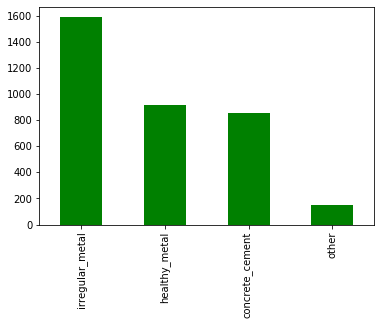

In [24]:
df_guatemala['roof_material'].value_counts().plot(kind='bar', color='green')

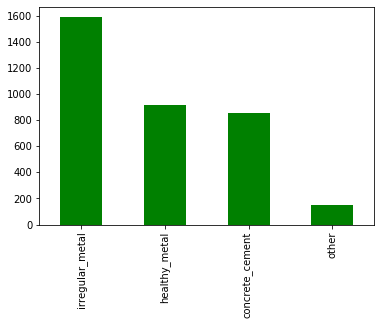

In [34]:
df_guatemala_valid['roof_material'].value_counts().plot(kind='bar', color='green')

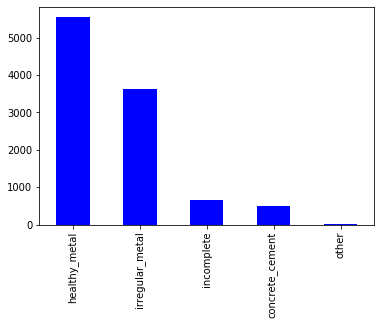

In [29]:
df_colombia['roof_material'].value_counts().plot(kind='bar', color='blue')

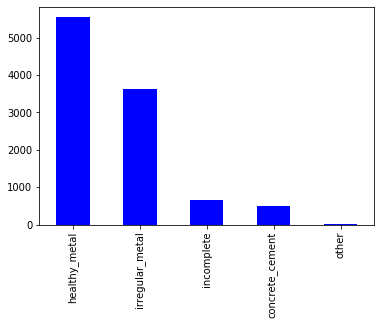

In [39]:
df_colombia_valid['roof_material'].value_counts().plot(kind='bar', color='blue')

In [40]:
df_invalid=df_all.loc[df_all['verified'] == False]

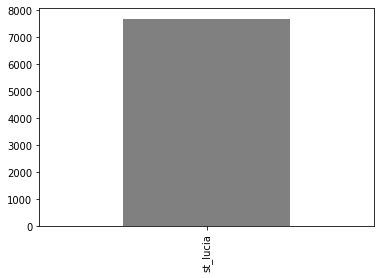

In [41]:
df_invalid['country'].value_counts().plot(kind='bar', color='gray')

In [43]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [44]:
df_test.tail()

id   country   region
7320  7a4f3ff4  st_lucia  dennery
7321  7a4fc578  st_lucia  dennery
7322  7a4ac7b2  st_lucia  dennery
7323  7a47e25e  st_lucia  dennery
7324  7a4e3f78  st_lucia  dennery

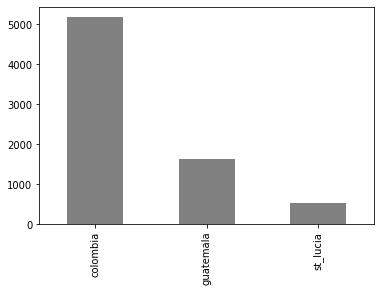

In [45]:
df_test['country'].value_counts().plot(kind='bar', color='gray')

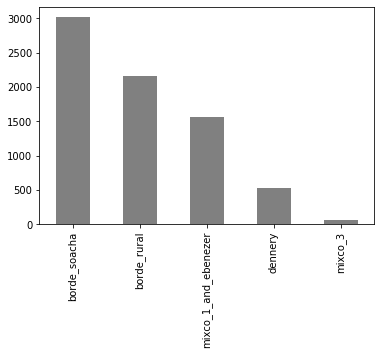

In [54]:
df_test['region'].value_counts().plot(kind='bar', color='gray')

In [24]:
assert len(df_test)==7325

In [25]:
df_all.loc[df_all['id'] == '7a204ec4']

id    roof_material  verified    country                region
12960  7a204ec4  irregular_metal      True  guatemala  mixco_1_and_ebenezer

In [26]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [27]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [28]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [29]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [30]:
#to check what params object has
#dir(data)

In [31]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [32]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

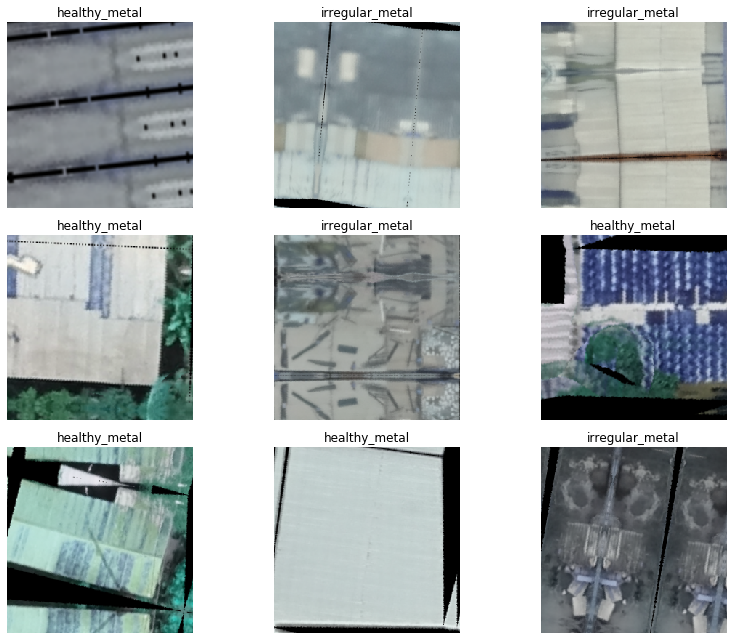

In [33]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [34]:
arch = models.resnet50
arch_name = 'rn50'

In [35]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [31]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

load the final 03_1 (submission 2) model

### reload

In [38]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 201),
 ('healthy_metal', 'irregular_metal', 121),
 ('incomplete', 'irregular_metal', 63),
 ('concrete_cement', 'healthy_metal', 37),
 ('other', 'healthy_metal', 36),
 ('healthy_metal', 'concrete_cement', 17),
 ('incomplete', 'healthy_metal', 17),
 ('incomplete', 'concrete_cement', 16),
 ('concrete_cement', 'irregular_metal', 14),
 ('irregular_metal', 'concrete_cement', 13),
 ('irregular_metal', 'incomplete', 9),
 ('healthy_metal', 'incomplete', 8),
 ('concrete_cement', 'incomplete', 7),
 ('other', 'irregular_metal', 7),
 ('healthy_metal', 'other', 3)]

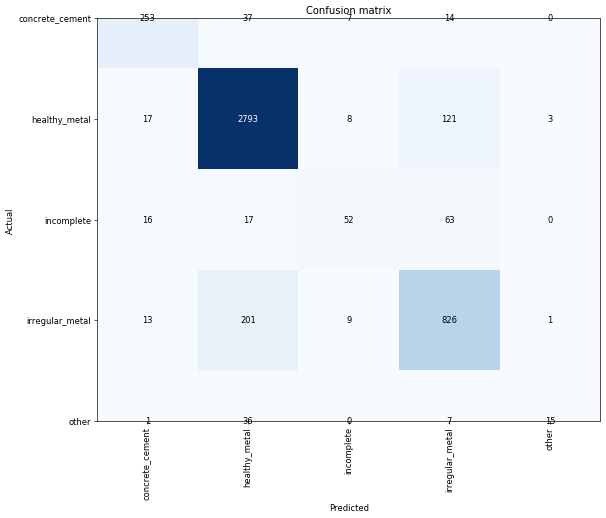

In [40]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### plot losses

In [154]:
def cl_int_plot_top_losses(interp, k, largest=True, figsize=(12,12), heatmap:bool=False, heatmap_thresh:int=16, 
                            alpha:float=0.6, cmap:str="magma", show_text:bool=True,
                            return_fig:bool=None, start_at=0)->Optional[plt.Figure]:
    '''Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.
    start_at - start at nth top loss'''

    assert not heatmap or _test_cnn(interp.model), "`heatmap=True` requires a model like `cnn_learner` produces."
    if heatmap is None: 
        heatmap = _test_cnn(interp.model)
    tl_val,tl_idx = interp.top_losses(k, largest)
    classes = interp.data.classes
    cols = math.ceil(math.sqrt(k-start_at))
    rows = math.ceil((k-start_at)/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    if show_text: 
        fig.suptitle('Prediction/Actual / Loss/Probability', weight='bold', size=14)
    fs=[]
    tl_val=tl_val[start_at:]
    tl_idx=tl_idx[start_at:]
    for i,idx in enumerate(tl_idx):
        im,cl = interp.data.dl(interp.ds_type).dataset[idx]
        cl = int(cl)
        f=interp.data.valid_ds.items[idx]
        f=f.split('/')[-1].split('.tif')[0]
        title = f'{f} {classes[interp.pred_class[idx]]}/{classes[cl]}/{interp.losses[idx]:.2f}/{interp.preds[idx][cl]:.2f}' if show_text else None
        im.show(ax=axes.flat[i], title=title)
        if heatmap:
            mult = interp.GradCAM(idx,interp.ds_type,heatmap_thresh,image=False)
            if mult is not None:
                sz = list(im.shape[-2:])
                axes.flat[i].imshow(mult, alpha=alpha, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap=cmap)
        fs.append(f)
    return fs

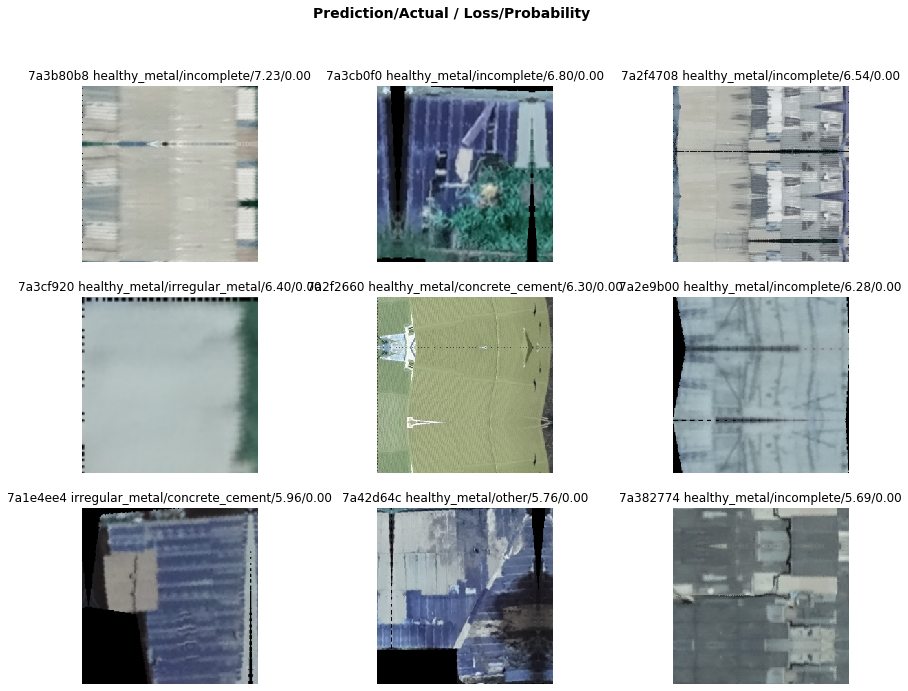

In [162]:
#prediction, actual, loss, and probability of actual class
fs0 = cl_int_plot_top_losses(interp, k=9, figsize=(15,11), start_at=0)

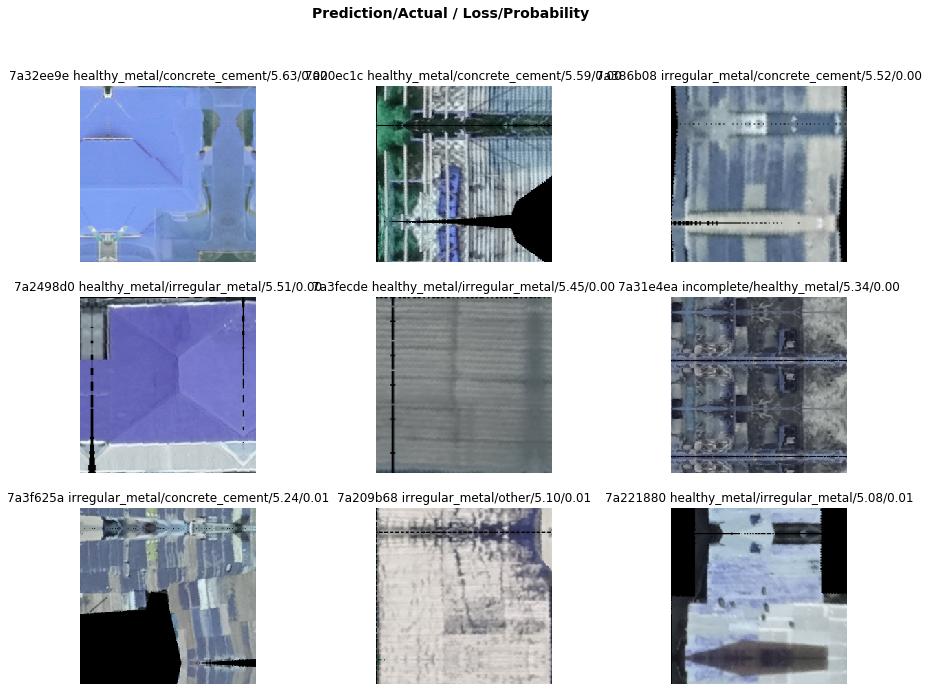

In [156]:
fs1 =cl_int_plot_top_losses(interp, k=18, figsize=(15,11), start_at=9)

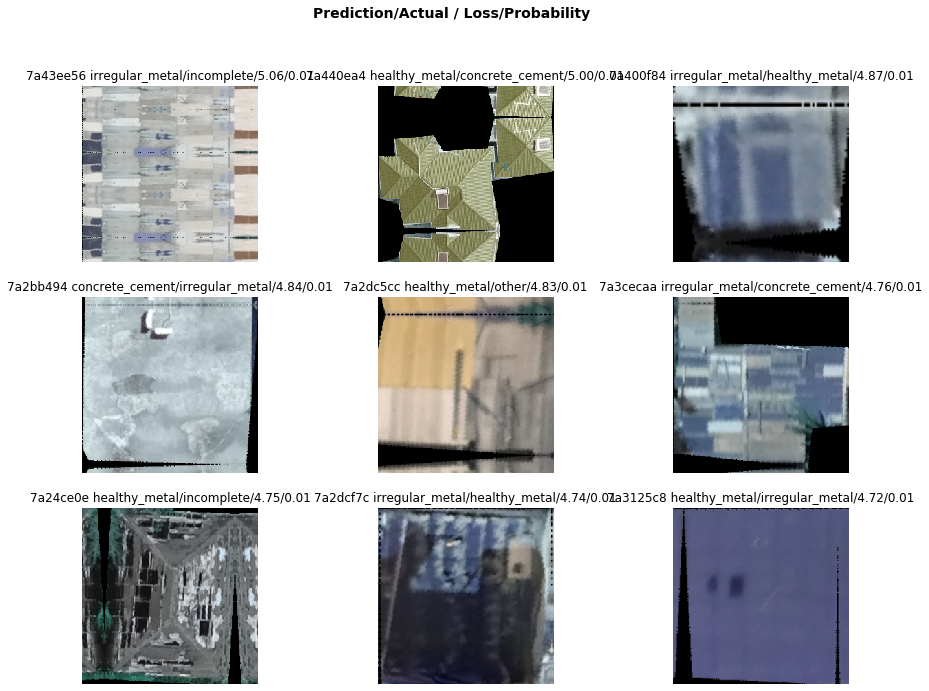

In [157]:
fs2 =cl_int_plot_top_losses(interp, k=27, figsize=(15,11), start_at=18)

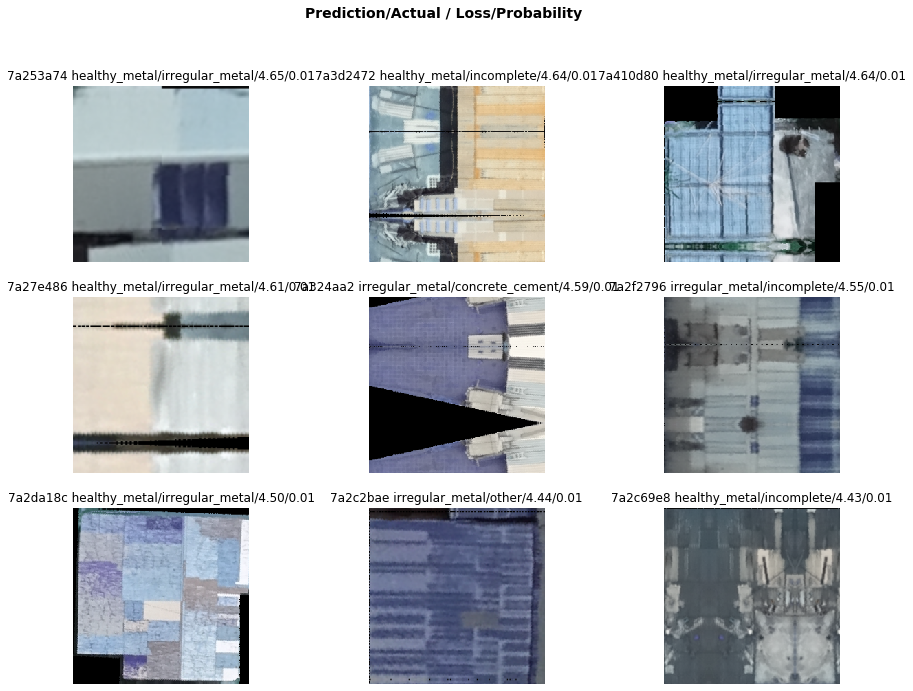

In [158]:
fs3 =cl_int_plot_top_losses(interp, k=36, figsize=(15,11), start_at=27)

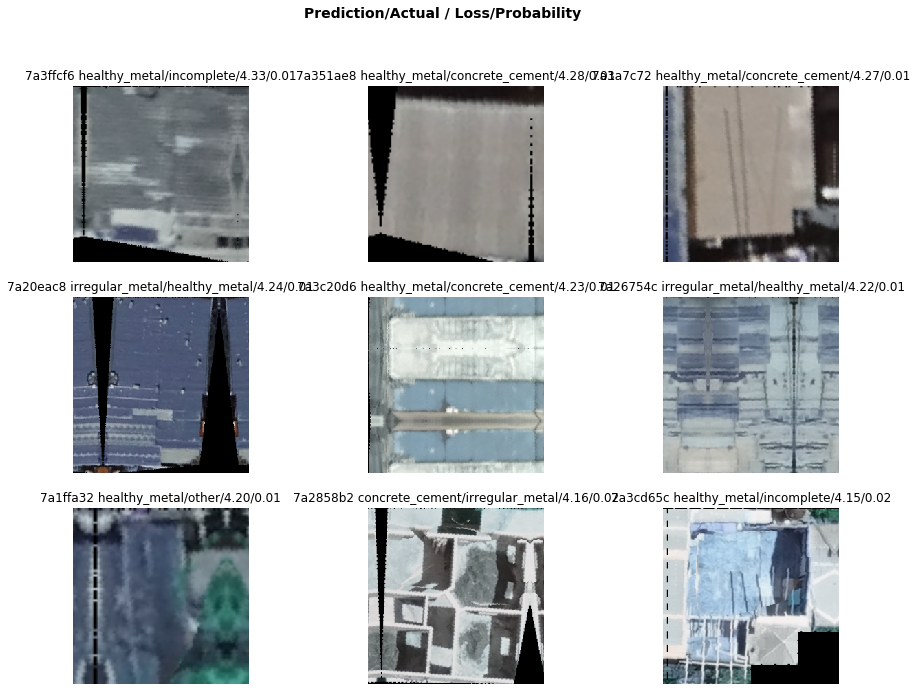

In [159]:
fs4 =cl_int_plot_top_losses(interp, k=45, figsize=(15,11), start_at=36)

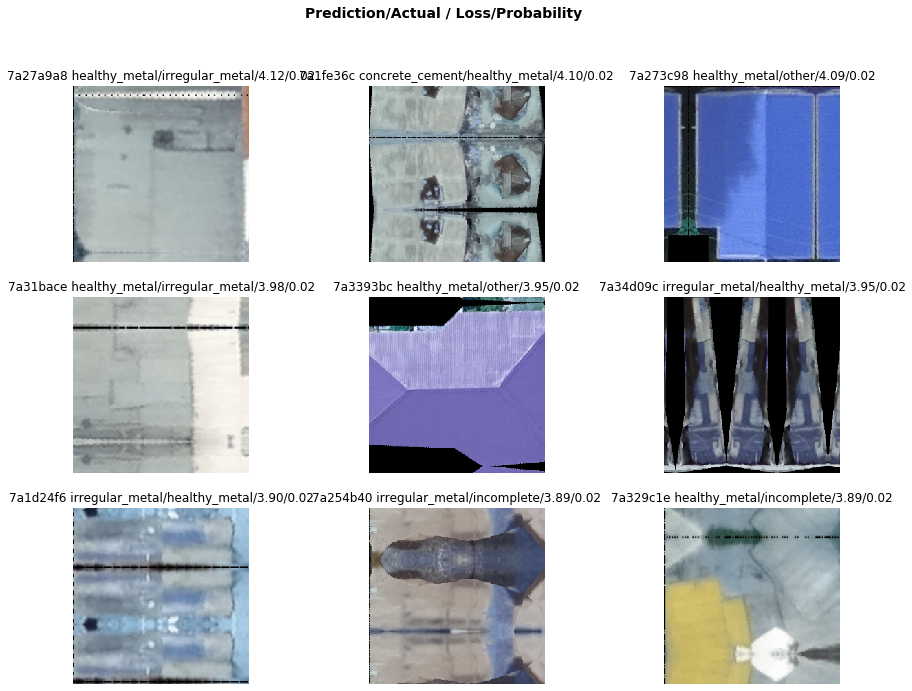

In [160]:
fs5 =cl_int_plot_top_losses(interp, k=54, figsize=(15,11), start_at=45)

In [174]:
fs = list(itertools.chain(fs0,fs1,fs2,fs3,fs4,fs5))

In [175]:
fs[0]

'7a3b80b8'

In [176]:
high_loss_df=df_all.loc[df_all['id'].isin(fs)]

In [177]:
high_loss_df['id_cat'] = pd.Categorical(
    high_loss_df['id'], 
    categories=fs, 
    ordered=True
)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [178]:
high_loss_df.head()

id    roof_material  verified   country       region    id_cat
34    7a329c1e       incomplete      True  colombia  borde_rural  7a329c1e
1056  7a3cf920  irregular_metal      True  colombia  borde_rural  7a3cf920
1599  7a382774       incomplete      True  colombia  borde_rural  7a382774
2703  7a254b40       incomplete      True  colombia  borde_rural  7a254b40
2946  7a3125c8  irregular_metal      True  colombia  borde_rural  7a3125c8

In [179]:
high_loss_df=high_loss_df.sort_values('id_cat')

In [181]:
high_loss_df.head(n=100)

id    roof_material  verified    country                region  \
3525   7a3b80b8       incomplete      True   colombia           borde_rural   
20560  7a3cb0f0       incomplete      True   st_lucia               dennery   
4596   7a2f4708       incomplete      True   colombia          borde_soacha   
1056   7a3cf920  irregular_metal      True   colombia           borde_rural   
22494  7a2f2660  concrete_cement     False   st_lucia            gros_islet   
4966   7a2e9b00       incomplete      True   colombia          borde_soacha   
12789  7a1e4ee4  concrete_cement      True  guatemala  mixco_1_and_ebenezer   
19788  7a42d64c            other      True   st_lucia               dennery   
1599   7a382774       incomplete      True   colombia           borde_rural   
19209  7a32ee9e  concrete_cement     False   st_lucia              castries   
14940  7a20ec1c  concrete_cement     False   st_lucia              castries   
13286  7a386b08  concrete_cement      True  guatemala  mixco_1_and_ebenezer   
19723  7a2498d0  irregular_metal      True   st_lucia               dennery   
8255   7a3fecde  irregular_metal      True   colombia          borde_soacha   
8761   7a31e4ea    healthy_metal      True   colombia          borde_soacha   
12784  7a3f625a  concrete_cement      True  guatemala  mixco_1_and_ebenezer   
4446   7a209b68            other      True   colombia          borde_soacha   
19707  7a221880  irregular_metal      True   st_lucia               dennery   
9601   7a43ee56       incomplete      True   colombia          borde_soacha   
22305  7a440ea4  concrete_cement     False   st_lucia            gros_islet   
13811  7a400f84    healthy_metal      True  guatemala               mixco_3   
20019  7a2bb494  irregular_metal      True   st_lucia               dennery   
13104  7a2dc5cc            other      True  guatemala  mixco_1_and_ebenezer   
12791  7a3cecaa  concrete_cement      True  guatemala  mixco_1_and_ebenezer   
19840  7a24ce0e       incomplete      True   st_lucia               dennery   
13581  7a2dcf7c    healthy_metal      True  guatemala  mixco_1_and_ebenezer   
2946   7a3125c8  irregular_metal      True   colombia           borde_rural   
19797  7a253a74  irregular_metal      True   st_lucia               dennery   
3222   7a3d2472       incomplete      True   colombia           borde_rural   
19951  7a410d80  irregular_metal      True   st_lucia               dennery   
13381  7a27e486  irregular_metal      True  guatemala  mixco_1_and_ebenezer   
8492   7a324aa2  concrete_cement      True   colombia          borde_soacha   
4420   7a2f2796       incomplete      True   colombia          borde_soacha   
19684  7a2da18c  irregular_metal      True   st_lucia               dennery   
11352  7a2c2bae            other      True  guatemala  mixco_1_and_ebenezer   
6179   7a2c69e8       incomplete      True   colombia          borde_soacha   
6688   7a3ffcf6       incomplete      True   colombia          borde_soacha   
11896  7a351ae8  concrete_cement      True  guatemala  mixco_1_and_ebenezer   
10987  7a3a7c72  concrete_cement      True  guatemala  mixco_1_and_ebenezer   
12536  7a20eac8    healthy_metal      True  guatemala  mixco_1_and_ebenezer   
22177  7a3c20d6  concrete_cement     False   st_lucia            gros_islet   
9619   7a26754c    healthy_metal      True   colombia          borde_soacha   
18118  7a1ffa32            other     False   st_lucia              castries   
20550  7a2858b2  irregular_metal      True   st_lucia               dennery   
20307  7a3cd65c       incomplete      True   st_lucia               dennery   
9622   7a27a9a8  irregular_metal      True   colombia          borde_soacha   
3662   7a1fe36c    healthy_metal      True   colombia           borde_rural   
15370  7a273c98            other     False   st_lucia              castries   
5019   7a31bace  irregular_metal      True   colombia          borde_soacha   
21948  7a3393bc            other     False   st_lucia          

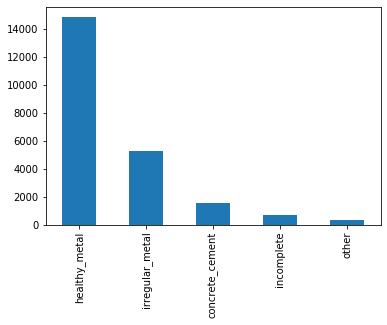

In [188]:
df_all['roof_material'].value_counts().plot(kind='bar')

Try generating more concrete, incomple and other roof types